In [313]:
import os
import csv
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.integrate import trapz

# Import Data

In [314]:
data_directory = "./IMU_Recordings"
file_names = ["01IMU.csv", "02IMU.csv", "03IMU.csv", "04IMU.csv", "05IMU.csv", "06IMU.csv", "07IMU.csv", "08IMU.csv", "09IMU.csv", "10IMU.csv", "11IMU.csv", "12IMU.csv", "13IMU.csv", "14IMU.csv", "15IMU.csv", "16IMU.csv", "17IMU.csv", "18IMU.csv"]
person_names = ["p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13", "p14", "p15", "p16", "p17", "p18"]

# Initialize dictionaries to store DataArrays for each person
acc_dict = {}
quat_dict = {}
time_dict = {}

In [315]:
for file_name, person_name in zip(file_names, person_names):
    # Construct the full path to the dataset file
    file_path = os.path.join(data_directory, file_name)

    # Load the dataset
    data = pd.read_csv(file_path)

    # Extract acceleration, quaternion, and time data from the dataset
    acc = np.array([data['Acc_X'], data['Acc_Y'], data['Acc_Z']])
    q = np.array([data['Quat_X'], data['Quat_Y'], data['Quat_Z'], data['Quat_W']])
    # Create a time array starting from 0 increasing by 1
    time = np.arange(len(data['SampleTimeFine']))

    # Reshape the quaternion array to have each quaternion as a row
    reshaped_q = np.transpose(q)

    # Convert to DataArrays
    acc_x = xr.DataArray(acc[0], dims=('time',), coords={'time': time})
    acc_y = xr.DataArray(acc[1], dims=('time',), coords={'time': time})
    acc_z = xr.DataArray(acc[2], dims=('time',), coords={'time': time})

    quat_x = xr.DataArray(q[0], dims=('time',), coords={'time': time})
    quat_y = xr.DataArray(q[1], dims=('time',), coords={'time': time})
    quat_z = xr.DataArray(q[2], dims=('time',), coords={'time': time})
    quat_w = xr.DataArray(q[3], dims=('time',), coords={'time': time})

    # Store DataArrays in dictionaries
    acc_dict[person_name] = xr.Dataset({'acc_x': acc_x, 'acc_y': acc_y, 'acc_z': acc_z})
    quat_dict[person_name] = reshaped_q
    time_dict[person_name] = time

In [316]:
# Add gender information for each person
acc_dict['p1']['gender'] = 'male'
acc_dict['p2']['gender'] = 'female'
acc_dict['p3']['gender'] = 'female'
acc_dict['p4']['gender'] = 'female'
acc_dict['p5']['gender'] = 'male'
acc_dict['p6']['gender'] = 'female'
acc_dict['p7']['gender'] = 'female'
acc_dict['p8']['gender'] = 'female'
acc_dict['p9']['gender'] = 'male'
acc_dict['p10']['gender'] = 'male'
acc_dict['p11']['gender'] = 'male'
acc_dict['p12']['gender'] = 'male'
acc_dict['p13']['gender'] = 'female'
acc_dict['p14']['gender'] = 'female'
acc_dict['p15']['gender'] = 'female'
acc_dict['p16']['gender'] = 'male'
acc_dict['p17']['gender'] = 'male'
acc_dict['p18']['gender'] = 'male'

# Gravity Compensation
First reshape acceleration data to the following format: p1([acc_x1, acc_y1, acc_z1], [acc_x2, acc_y2, acc_z2], ...)

In [317]:
# Initialize a dictionary to store reshaped acceleration data
reshaped_acc_dict = {}

# Iterate over each person's dataset
for person_name, acc_dataset in acc_dict.items():
    # Reshape the acceleration data
    reshaped_acc = np.array([acc_dataset['acc_x'], acc_dataset['acc_y'], acc_dataset['acc_z']])
    
    # Transpose to have each acceleration component as a row
    reshaped_acc = np.transpose(reshaped_acc)
    
    # Store reshaped acceleration data in the dictionary
    reshaped_acc_dict[person_name] = reshaped_acc

Convert the acceleration data from the sensor data frame to global data frame and subtract gravity in the z-axis.

In [318]:
# Gravitation as array [x, y, z]
g = np.array([0, 0, 9.81])

# Iterate over each person's quaternion dataset
for person_name, quat_data in quat_dict.items():
    # Get the reshaped acceleration data for the current person
    acc_data = reshaped_acc_dict[person_name]
    
    # Get the number of samples
    num_samples = quat_data.shape[0]
    
    # Initialize array to store global acceleration for the current person
    acc_global = np.zeros((num_samples, 3))
    
    # Iterate over each sample
    for i in range(num_samples):
        # Convert quaternion to rotation matrix
        r = Rotation.from_quat(quat_data[i]).as_matrix()
        
        # Multiply rotation matrix with measured acceleration and subtract gravity
        acc_global[i] = np.dot(r, acc_data[i]) - g
    
    # Extract time data
    time = time_dict[person_name]
    
    # Create DataArray objects for each axis
    acc_x_global = xr.DataArray(acc_global[:, 0], dims=('time',), coords={'time': time})
    acc_y_global = xr.DataArray(acc_global[:, 1], dims=('time',), coords={'time': time})
    acc_z_global = xr.DataArray(acc_global[:, 2], dims=('time',), coords={'time': time})
    
    # Add global acceleration DataArray objects to acc_dict
    acc_dict[person_name]['acc_x_global'] = acc_x_global
    acc_dict[person_name]['acc_y_global'] = acc_y_global
    acc_dict[person_name]['acc_z_global'] = acc_z_global

# Calculate Derivative

In [319]:
# Calculate the derivative for acc_x, acc_y, and acc_z for each person
for person_name in acc_dict:
    # Select the dataset for the current person
    acc_dataset = acc_dict[person_name]
    
    # Calculate the derivative for acc_x, acc_y, and acc_z
    acc_dataset['acc_x_derivative'] = acc_dataset['acc_x_global'].differentiate('time')
    acc_dataset['acc_y_derivative'] = acc_dataset['acc_y_global'].differentiate('time')
    acc_dataset['acc_z_derivative'] = acc_dataset['acc_z_global'].differentiate('time')

# Normalization
## Jerkvalues

Normalization of the jerk using local maximum value

In [320]:
for person_name in acc_dict:
    # Select the dataset for the current person
    acc_dataset = acc_dict[person_name]
    acc_x_derivative = acc_dataset['acc_x_derivative']
    acc_y_derivative = acc_dataset['acc_y_derivative']
    acc_z_derivative = acc_dataset['acc_z_derivative']
    
    # Normalize derivatives
    max_acc_x_derivative = np.max(np.abs(acc_x_derivative))
    max_acc_y_derivative = np.max(np.abs(acc_y_derivative))
    max_acc_z_derivative = np.max(np.abs(acc_z_derivative))
    
    acc_x_derivative_normalized = acc_x_derivative / max_acc_x_derivative
    acc_y_derivative_normalized = acc_y_derivative / max_acc_y_derivative
    acc_z_derivative_normalized = acc_z_derivative / max_acc_z_derivative
    
    # Store normalized derivatives back into the dataset
    acc_dataset['acc_x_derivative_normalized'] = acc_x_derivative_normalized
    acc_dataset['acc_y_derivative_normalized'] = acc_y_derivative_normalized
    acc_dataset['acc_z_derivative_normalized'] = acc_z_derivative_normalized

Normalization using global maximum 

First compute each persons maximum of absolute values and then find global maximum of local maximums in order to have a faster performance

In [321]:
# Initialize lists to store maximum derivative values for each person
max_acc_x_derivative_list = []
max_acc_y_derivative_list = []
max_acc_z_derivative_list = []
time = []

# Compute maximum derivative values for each person
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    max_acc_x_derivative = np.max(np.abs(acc_dataset['acc_x_derivative']))
    max_acc_y_derivative = np.max(np.abs(acc_dataset['acc_y_derivative']))
    max_acc_z_derivative = np.max(np.abs(acc_dataset['acc_z_derivative']))
    timesteps = acc_dataset['time']
    
    max_acc_x_derivative_list.append(max_acc_x_derivative)
    max_acc_y_derivative_list.append(max_acc_y_derivative)
    max_acc_z_derivative_list.append(max_acc_z_derivative)
    time.append(timesteps[-1])

# Find the global maximum among the maximum derivative values for all persons
max_acc_x_derivative_global = np.max(max_acc_x_derivative_list)
max_acc_y_derivative_global = np.max(max_acc_y_derivative_list)
max_acc_z_derivative_global = np.max(max_acc_z_derivative_list)
max_timesteps = np.max(time)

# Normalize derivatives for each person using the global maximum
for person_name in acc_dict:
    acc_dataset = acc_dict[person_name]
    acc_x_derivative = acc_dataset['acc_x_derivative']
    acc_y_derivative = acc_dataset['acc_y_derivative']
    acc_z_derivative = acc_dataset['acc_z_derivative']
    timesteps = acc_dataset['time']
    
    acc_x_derivative_normalized = acc_x_derivative / max_acc_x_derivative_global
    acc_y_derivative_normalized = acc_y_derivative / max_acc_y_derivative_global
    acc_z_derivative_normalized = acc_z_derivative / max_acc_z_derivative_global
    time_normalized = timesteps / max_timesteps
    
    # Store normalized derivatives back into the dataset
    acc_dataset['acc_x_derivative_normalized_global'] = acc_x_derivative_normalized
    acc_dataset['acc_y_derivative_normalized_global'] = acc_y_derivative_normalized
    acc_dataset['acc_z_derivative_normalized_global'] = acc_z_derivative_normalized
    acc_dataset['time_normalized'] = time_normalized

Eucledian Norm of the jerk

In [322]:
# Calculate the derivative for acc_x, acc_y, and acc_z for each person
for person_name in acc_dict:
    # Select the dataset for the current person
    acc_dataset = acc_dict[person_name]
    
    # Calculate the derivative for acc_x, acc_y, and acc_z
    acc_x_derivative = acc_dataset['acc_x_global'].differentiate('time')
    acc_y_derivative = acc_dataset['acc_y_global'].differentiate('time')
    acc_z_derivative = acc_dataset['acc_z_global'].differentiate('time')
    
    # Normalize derivatives
    sum_sqr_acc_x_derivative = np.sum(acc_x_derivative ** 2)
    sum_sqr_acc_y_derivative = np.sum(acc_y_derivative ** 2)
    sum_sqr_acc_z_derivative = np.sum(acc_z_derivative ** 2)
    
    acc_x_derivative_norm = np.sqrt(sum_sqr_acc_x_derivative)
    acc_y_derivative_norm = np.sqrt(sum_sqr_acc_y_derivative)
    acc_z_derivative_norm = np.sqrt(sum_sqr_acc_z_derivative)
    
    # Store normalized derivatives back into the dataset
    acc_dataset['acc_x_derivative_norm'] = acc_x_derivative_norm
    acc_dataset['acc_y_derivative_norm'] = acc_y_derivative_norm
    acc_dataset['acc_z_derivative_norm'] = acc_z_derivative_norm


Plotting the comparisons

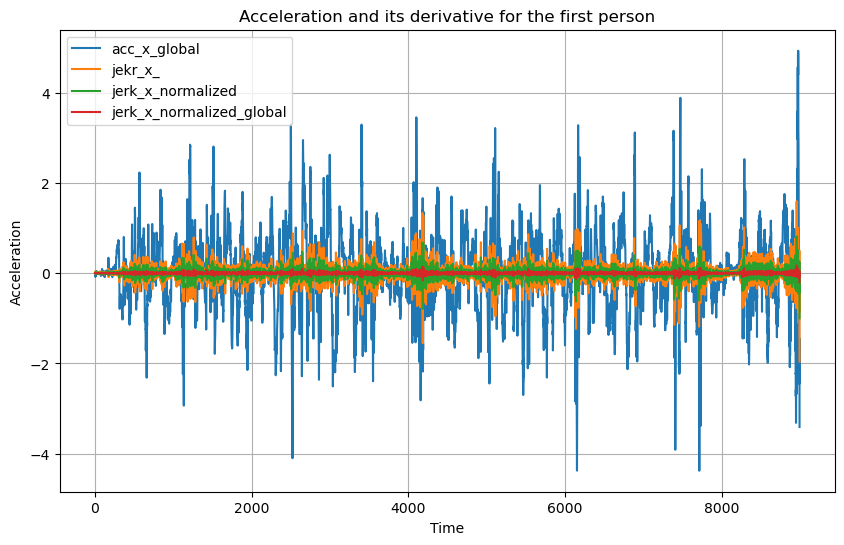

In [323]:
# Select the dataset for the first person
first_person_acc = acc_dict[person_names[0]]

# Plot acc_x and its derivative
plt.figure(figsize=(10, 6))
plt.plot(first_person_acc['time'], first_person_acc['acc_x_global'], label='acc_x_global')
plt.plot(first_person_acc['time'], first_person_acc['acc_x_derivative'], label='jekr_x_')
plt.plot(first_person_acc['time'], first_person_acc['acc_x_derivative_normalized'], label='jerk_x_normalized')
plt.plot(first_person_acc['time'], first_person_acc['acc_x_derivative_normalized_global'], label='jerk_x_normalized_global')
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.title('Acceleration and its derivative for the first person')
plt.legend()
plt.grid(True)
plt.show()

Plot all normalized jerk values

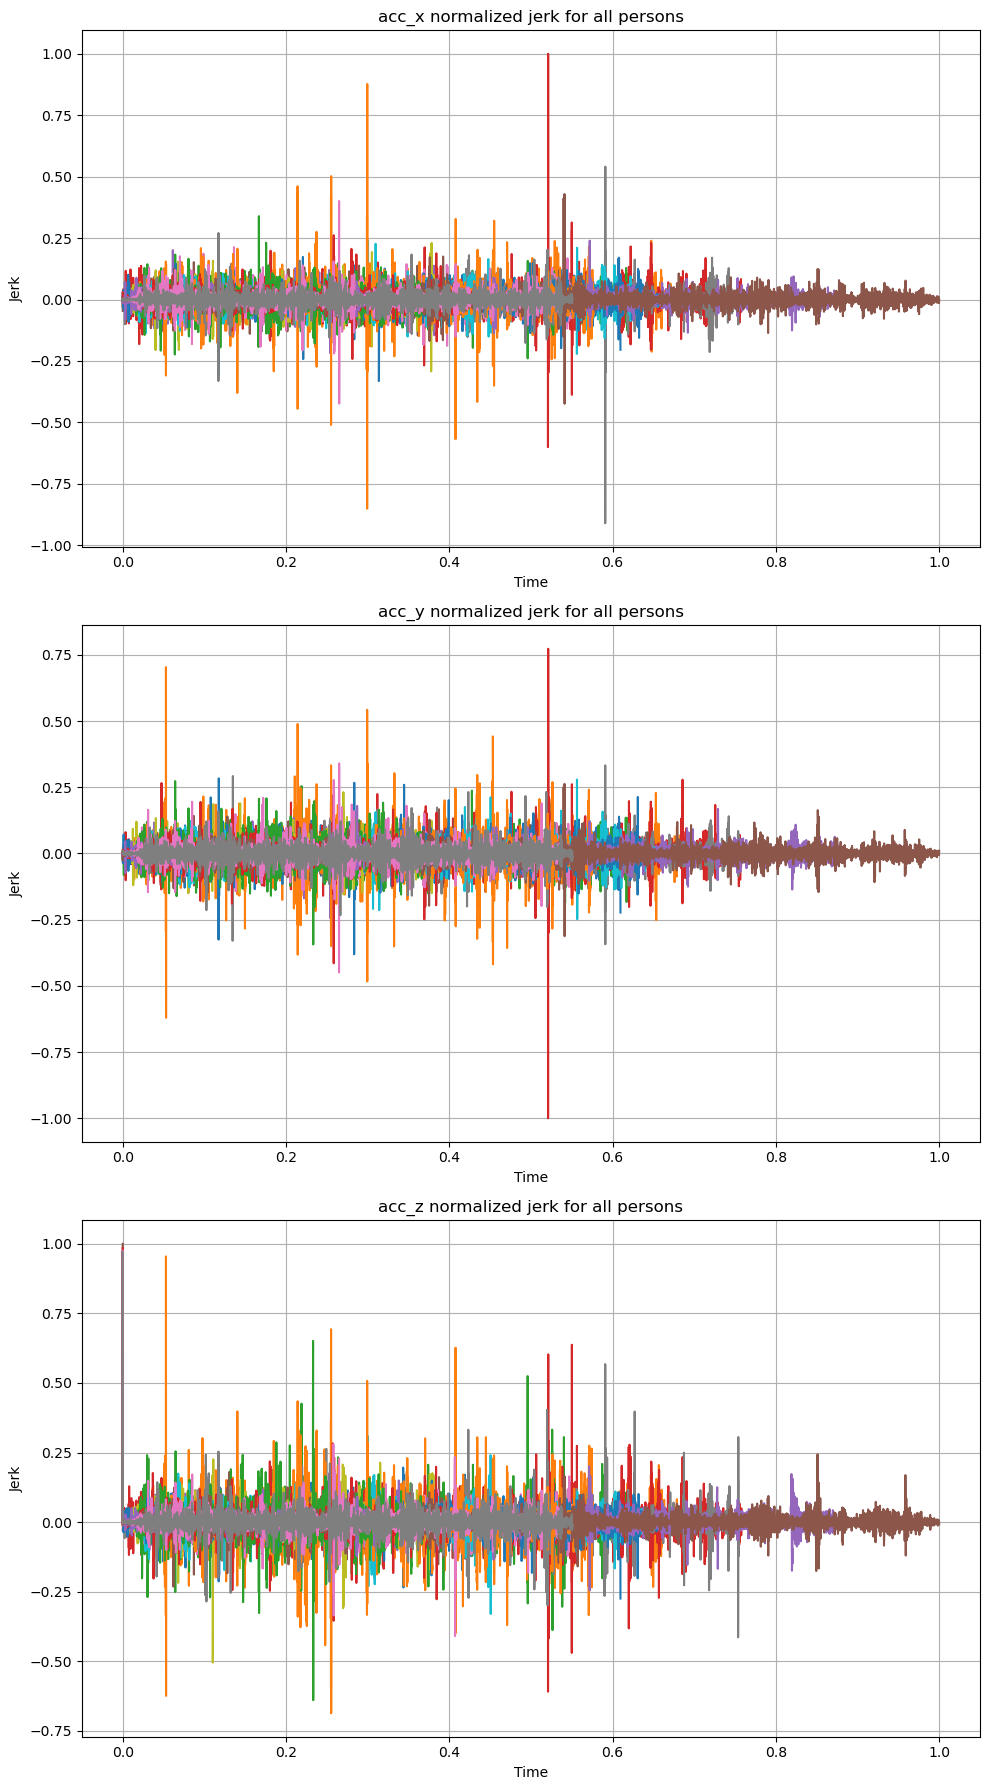

In [324]:
# Define the number of subplots
num_axes = 3

# Create subplots
fig, axs = plt.subplots(num_axes, 1, figsize=(10, 18))

# Iterate over each axis
for i, axis in enumerate(['acc_x', 'acc_y', 'acc_z']):
    axs[i].set_title(f'{axis} normalized jerk for all persons')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Jerk')
    axs[i].grid(True)

    # Plot each person's data
    for person_name in person_names:
        person_data = acc_dict[person_name]
        axs[i].plot(person_data['time_normalized'], person_data[f'{axis}_derivative_normalized_global'], label=f'{person_name} jerk_{axis}_normalized')

# Adjust layout
plt.tight_layout()
plt.show()

## Time
Calculate C

In [325]:
# Calculate the normalization constant C
for person_name in acc_dict:
    # Select the dataset for the current person
    acc_dataset = acc_dict[person_name]
    
    # Calculate the normalization constant C
    timesteps = acc_dataset['time']
    # time = timesteps[-1] / 120
    time = max_timesteps / 120
    C = (time ** 5) / (12 ** 2)
    acc_dataset['C'] = C

Compare C and measured time

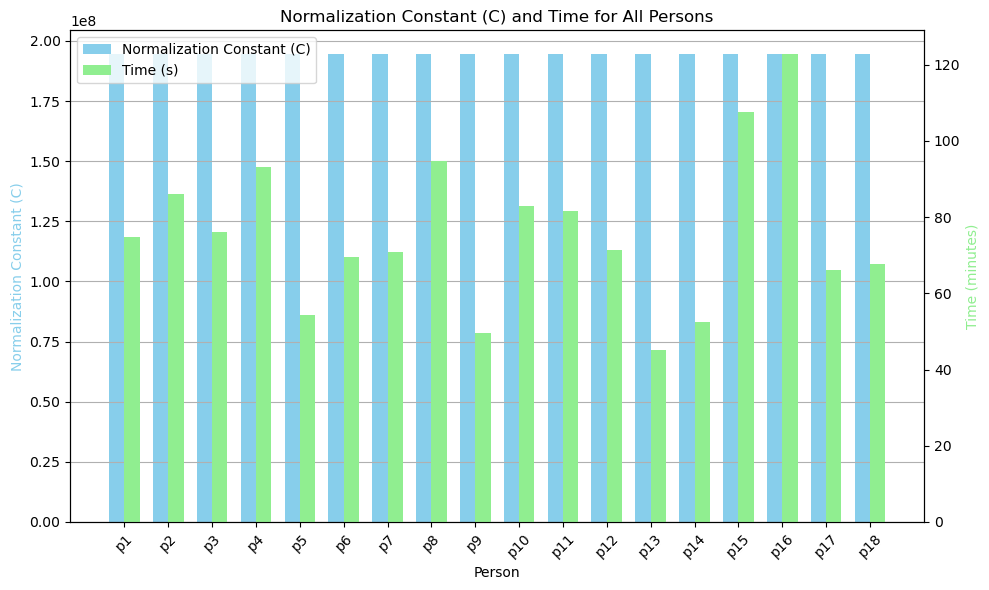

In [326]:
# Initialize lists to store person names, their corresponding C values, and time values
person_names = []
c_values = []
time_values = []

# Iterate over each person's data
for person_name, acc_dataset in acc_dict.items():
    # Append person name, C value, and time value to lists
    person_names.append(person_name)
    c_values.append(acc_dataset['C'])
    time_values.append(acc_dataset['time'][-1] / 120)  # Convert to seconds

# Set the width of the bars
bar_width = 0.35

# Define the positions for the bars
r1 = np.arange(len(person_names))
r2 = [x + bar_width for x in r1]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot C values for all persons on primary axis
ax1.bar(r1, c_values, color='skyblue', width=bar_width, label='Normalization Constant (C)')
ax1.set_xlabel('Person')
ax1.set_ylabel('Normalization Constant (C)', color='skyblue')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y')

# Create secondary axis for time values
ax2 = ax1.twinx()
ax2.bar(r2, time_values, color='lightgreen', width=bar_width, label='Time (s)')
ax2.set_ylabel('Time (minutes)', color='lightgreen')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Adjust x-axis ticks
plt.xticks([r + bar_width / 2 for r in range(len(person_names))], person_names, rotation=45, ha='right')

# Adjust layout
plt.title('Normalization Constant (C) and Time for All Persons')
plt.tight_layout()
plt.show()

Calculate integrated normalized jerk

Using absolute values to also compute negative peaks

In [327]:
# Initialize dictionary to store integrated values for each axis
jerk_values = {'acc_x': {}, 'acc_y': {}, 'acc_z': {}}

# Calculate the integral for acc_x_derivative_normalized, acc_y_derivative_normalized, and acc_z_derivative_normalized for each person
for person_name in acc_dict:
    # Select the dataset for the current person
    acc_dataset = acc_dict[person_name]
    
    # Get the time array
    time = acc_dataset['time']
    C = acc_dataset['C'].values
    
    # Iterate over each axis
    for axis in ['acc_x', 'acc_y', 'acc_z']:
        # Get the normalized derivative for the current axis
        jerk = (acc_dataset[f'{axis}_derivative_normalized_global'])
        
        # Integrate the normalized derivative over time
        integral_value = trapz((jerk ** 2), time)
        jerk = C * integral_value
        
        # Store the integrated value for the current person and axis
        jerk_values[axis][person_name] = jerk

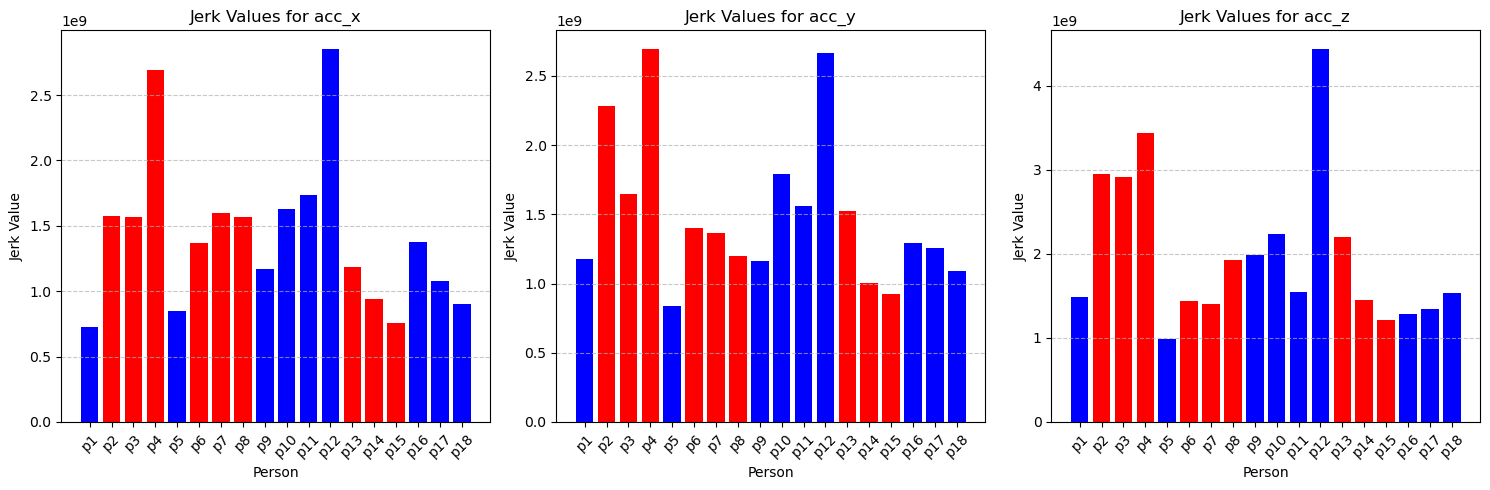

In [328]:
# Define the axes
axes = ['acc_x', 'acc_y', 'acc_z']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the integrated values for each axis
for i, axis in enumerate(axes):
    # Extract person names, integrated values, and genders
    person_names = list(jerk_values[axis].keys())
    values = list(jerk_values[axis].values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Define colors based on gender
    colors = ['red' if gender == 'female' else 'blue' for gender in genders]
    
    # Plot the integrated values with colors
    axs[i].bar(person_names, values, color=colors)
    axs[i].set_xlabel('Person')
    axs[i].set_ylabel('Jerk Value')
    axs[i].set_title(f'Jerk Values for {axis}')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [329]:
# Initialize dictionaries to store mean integrated values for women and men
jerk_values_women = {'acc_x': [], 'acc_y': [], 'acc_z': []}
jerk_values_men = {'acc_x': [], 'acc_y': [], 'acc_z': []}

# Iterate over integrated values for each axis
for axis, values in jerk_values.items():
    # Extract person names, integrated values, and genders
    person_names = list(values.keys())
    values = list(values.values())
    genders = [acc_dict[person_name]['gender'] for person_name in person_names]
    
    # Iterate over each person's integrated value
    for person_name, jerk_value, gender in zip(person_names, values, genders):
        # Check gender and append the integrated value to the corresponding list
        if gender == 'female':
            jerk_values_women[axis].append(jerk_value)
        elif gender == 'male':
            jerk_values_men[axis].append(jerk_value)

# Calculate the mean of jerk_values_gender for each axis
mean_jerk_values_women = {axis: np.mean(values) for axis, values in jerk_values_women.items()}
std_jerk_values_women = {axis: np.std(values) for axis, values in jerk_values_women.items()}
mean_jerk_values_men = {axis: np.mean(values) for axis, values in jerk_values_men.items()}
std_jerk_values_men = {axis: np.std(values) for axis, values in jerk_values_men.items()}


In [330]:
# Define the file name
filename = "jerk_values.csv"

# Combine mean and standard deviation values for women and men
summary_data = {
    "Axis": [],
    "Jerk_Women": [],
    "Jerk_Men": []
}

# Append the data for each axis
for axis in jerk_values_women.keys():
    summary_data["Axis"].append(axis)
    summary_data["Jerk_Women"].append(jerk_values_women[axis])
    summary_data["Jerk_Men"].append(jerk_values_men[axis])

# Write data to CSV file
with open(filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=summary_data.keys())
    writer.writeheader()
    for i in range(len(summary_data["Axis"])):
        writer.writerow({key: summary_data[key][i] for key in summary_data.keys()})

print(f"Data exported to {filename}")

PermissionError: [Errno 13] Permission denied: 'jerk_values.csv'